In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_validate
import statsmodels.api as sm
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
C:\Users\amits\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [9]:
df = pd.read_csv(r"D:/Summer/STA/archive/dataset_phishing.csv")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Summer/STA/archive/dataset_phishing.csv'

In [10]:
df.shape

NameError: name 'df' is not defined

In [11]:
def plot_ROC(Y_test, Y_test_pred, classifier):
    fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_test_pred)
    roc_auc = metrics.auc(fpr, tpr)
    #create ROC curve
    plt.plot(fpr,tpr, color="darkorange",
        lw=2,
        label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC for "+ classifier)
    plt.legend(loc="lower right")
    plt.show()
    
def plot_confusion_matrix(Y_test, Y_test_pred, classifier):
    cm = confusion_matrix(Y_test, Y_test_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

def plot_recall_results(y_true, y_test_pred):
    precision_dict = {}
    recall_dict = {}
    for i in np.arange(0,1,0.1):
        threshold = i
        thr_op = (y_test_pred >= threshold).astype(int)
        cfm = confusion_matrix(y_true,thr_op)
        
        #calculating recall and precision
        recall = cfm[1][1]/(cfm[1][0]+cfm[1][1])
        precision = cfm[1][1]/(cfm[1][1]+cfm[0][1])
        
        #creating dictionary of threshold as key and accuracy as value
        precision_dict["{:.2f}".format(i)]=precision
        recall_dict["{:.2f}".format(i)]=recall
        
    x, recall = zip(*sorted(recall_dict.items())) 
    y, precision = zip(*sorted(precision_dict.items())) 
    
    # Plot precision vs. recall
    plt.plot(x, recall, label = "Recall")
    plt.plot(x, precision, label = "Precision")
    plt.xlabel('Threshold')
    plt.ylabel('Precision and Recall')
    plt.legend()
    plt.grid()
    plt.show()
    return precision_dict, recall_dict


In [5]:
# Relabeling to binary
df['Y'] = df['status'].apply(lambda x: 0 if x == 'legitimate' else 1)
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status,Y
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,1,0,45,-1,0,1,1,4,legitimate,0
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,0,0,77,5767,0,0,1,2,phishing,1
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,0,0,14,4004,5828815,0,1,0,phishing,1
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,0,0,62,-1,107721,0,0,3,legitimate,0
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,1,0,224,8175,8725,0,0,6,legitimate,0


In [6]:
def parse_url(url):
    try:
        no_scheme = not url.startswith('https://') and not url.startswith('http://')
        if no_scheme:
            parsed_url = urlparse(f"http://{url}")
            return {
                "scheme": None, # not established a value for this
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
        else:
            parsed_url = urlparse(url)
            return {
                "scheme": parsed_url.scheme,
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
    except:
        return None

# Expand the dictionary
df["parsed_url"] = df.url.apply(parse_url)
df = pd.concat([
    df.drop(['parsed_url'], axis=1),
    df['parsed_url'].apply(pd.Series)
], axis=1)
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,google_index,page_rank,status,Y,scheme,netloc,path,params,query,fragment
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,1,4,legitimate,0,http,www.crestonwood.com,/router.php,,,
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,2,phishing,1,http,shadetreetechnology.com,/V4/validation/a111aedc8ae390eabcfa130e041a10a4,,,
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,phishing,1,https,support-appleld.com.secureupdate.duilawyeryork...,/ap/89e6a3b4b063b8d/,,cmd=_update&dispatch=89e6a3b4b063b8d1b&locale=_,
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,0,3,legitimate,0,http,rgipt.ac.in,,,,
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,6,legitimate,0,http,www.iracing.com,/tracks/gateway-motorsports-park/,,,


In [7]:
# Feature extraction
df["length"] = df.url.str.len()
df["is_ip"] = df.netloc.str.match(r"\d+\.\d+\.\d+\.\d+").astype(int)
df['domain_hyphens'] = df.netloc.str.count('-')
df['domain_underscores'] = df.netloc.str.count('_')
df['path_hyphens'] = df.path.str.count('-')
df['path_underscores'] = df.path.str.count('_')
df['slashes'] = df.path.str.count('/')
df['full_stops'] = df.path.str.count('.')

In [8]:
features = [ 'domain_hyphens', 'path_hyphens', 'path_underscores', 'slashes', 'google_index', 'ratio_digits_url', 'phish_hints', 'nb_www', 
                'domain_in_title']
df_X = df[features]
df_Y = df['Y']

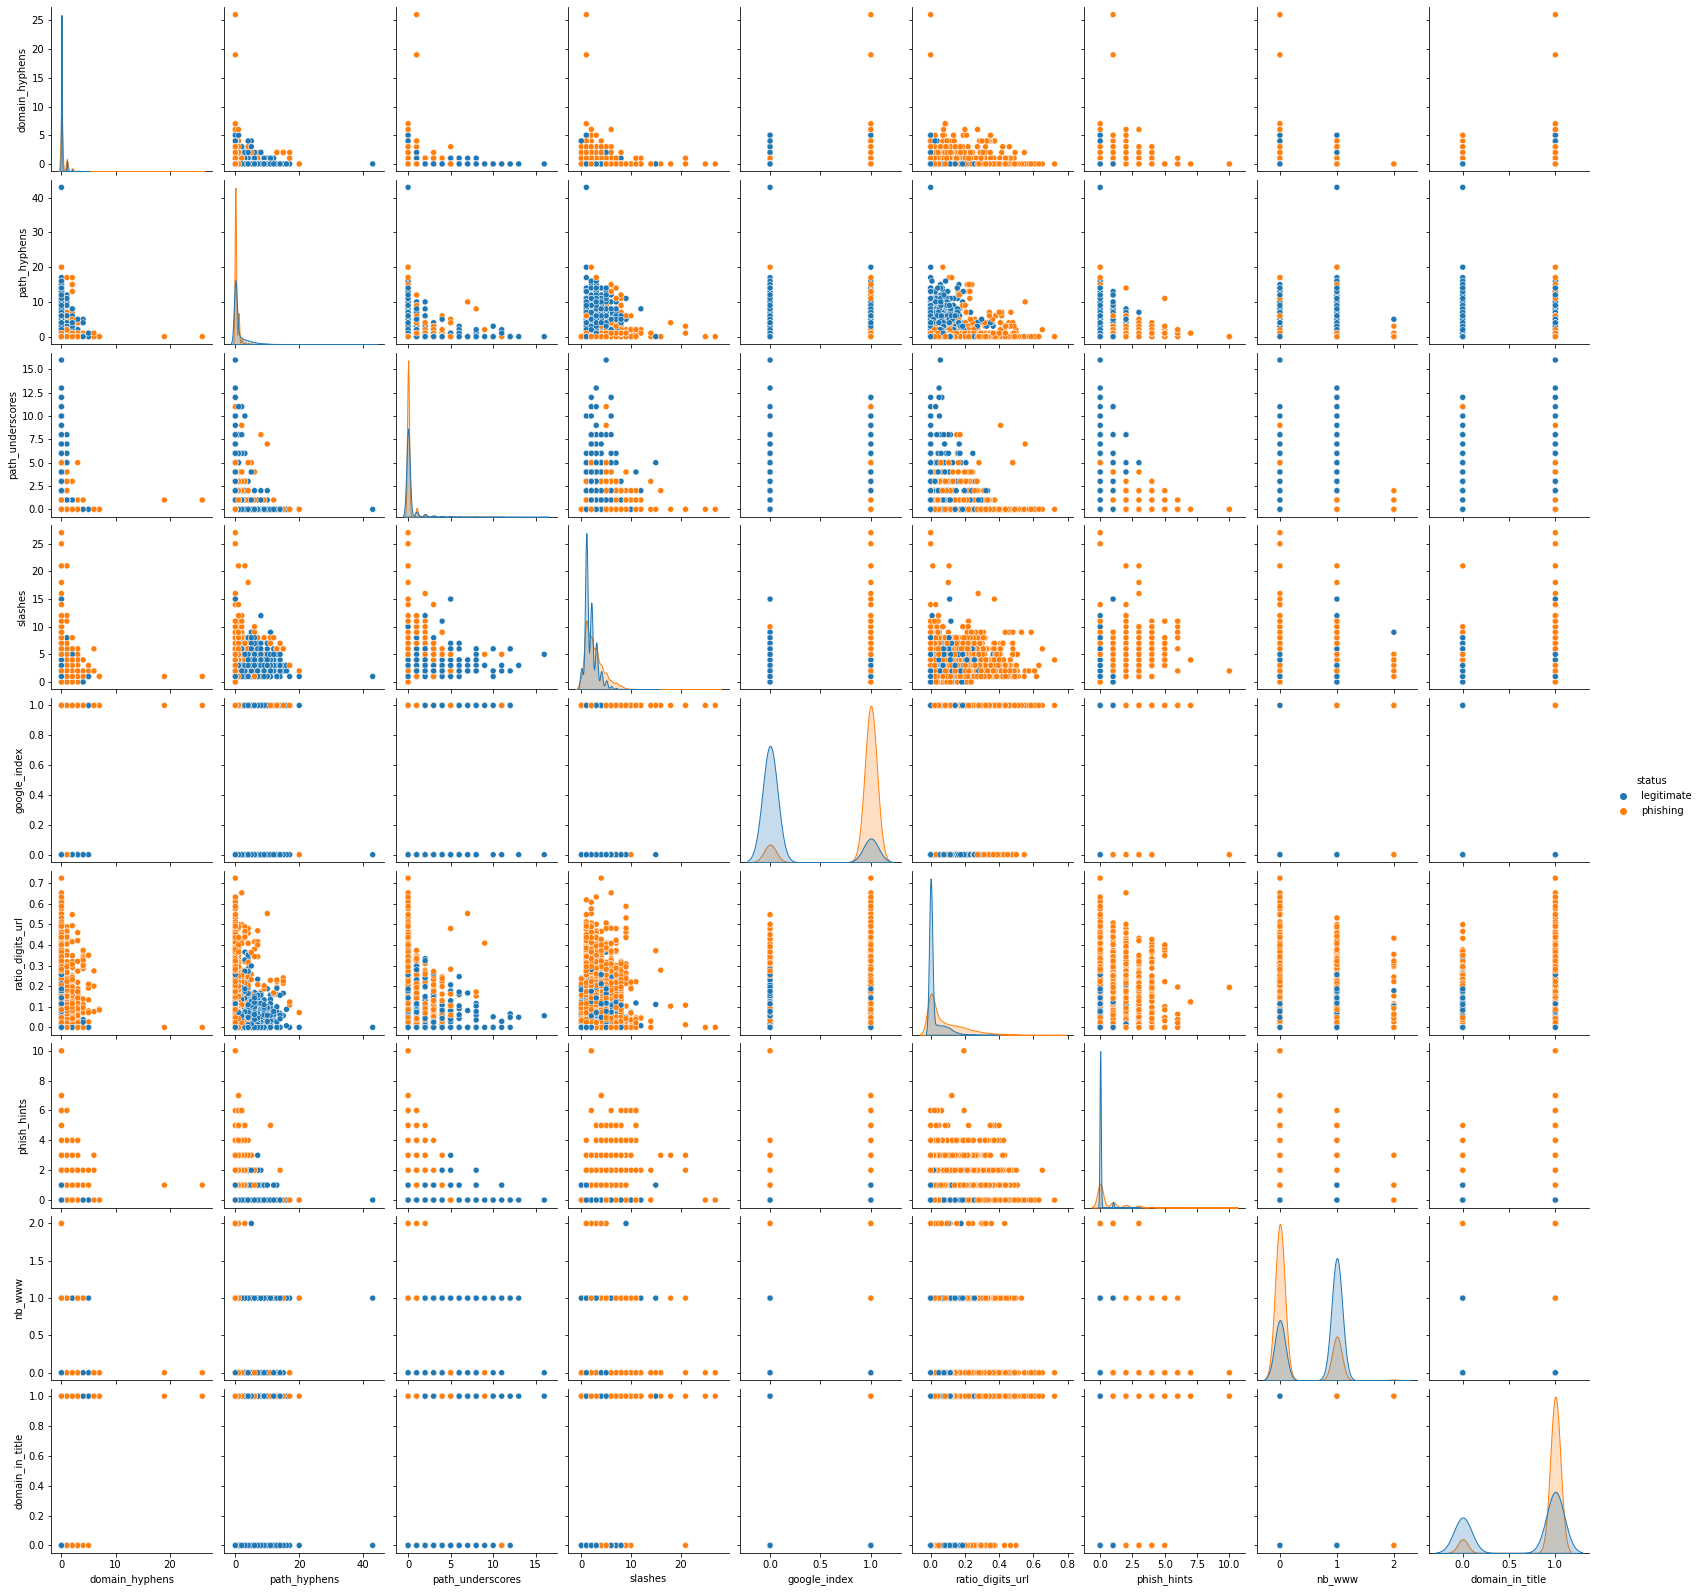

In [9]:
sns.pairplot(df, vars=features, hue= 'status', diag_kws={'bw': 0.2})

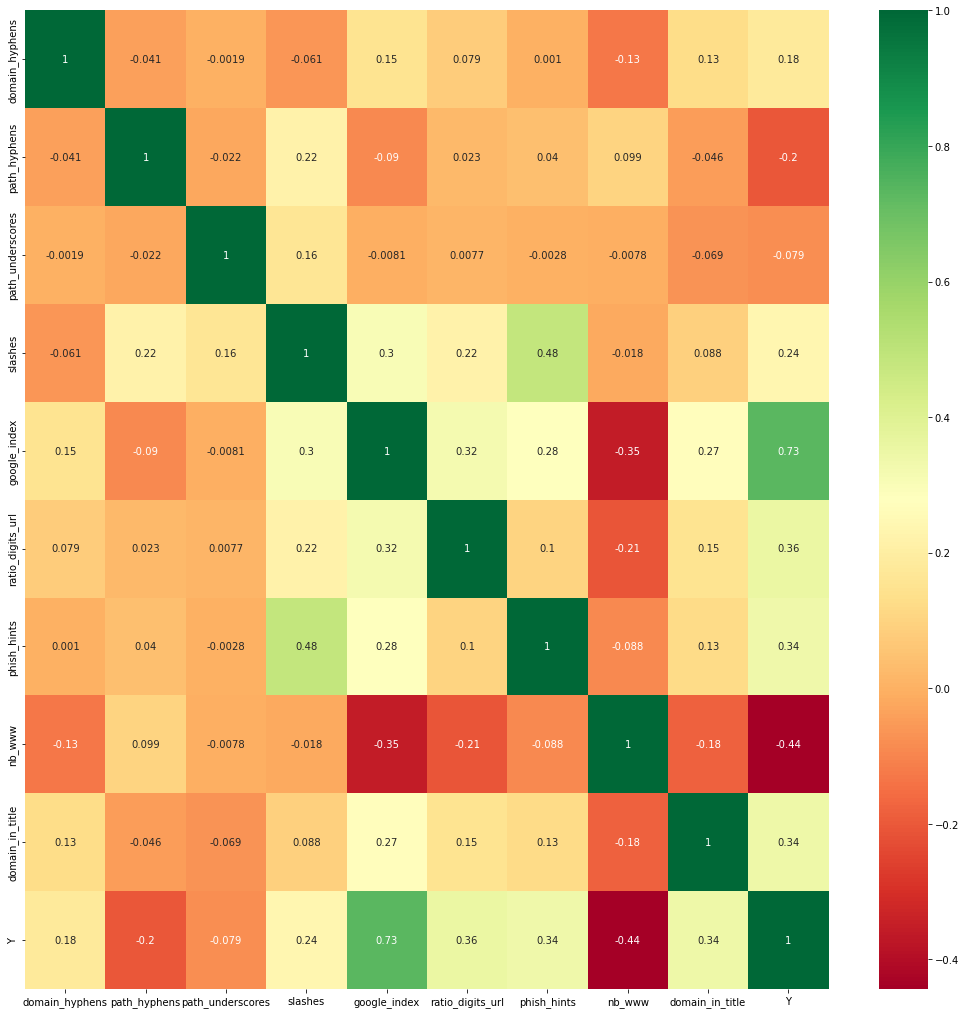

In [10]:
plt.figure(figsize=(18,18))

sns.heatmap(df[features +['Y']].corr(), annot=True, cmap='RdYlGn')

plt.show()

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state = 420)

In [12]:
scaler = MinMaxScaler()
fit = scaler.fit(df_X)
fitted_X_train = fit.transform(X_train)
fitted_X_test = fit.transform(X_test)

### Logistic Regression Classifier - Model 1 (Basis EDA)

In [13]:
# Cross-validate on train data
clf = LogisticRegression(random_state=420)
scores = cross_validate(clf, fitted_X_train, Y_train,
                        scoring='recall', cv=4, return_train_score = True)
print('Mean train sets Recall for Logistic Regression : {0:.4f}'.format(scores['train_score'].mean()))
print('Mean test sets Recall for Logistic Regression : {0:.4f}'.format(scores['test_score'].mean()))

Mean train sets Recall for Logistic Regression : 0.9023
Mean test sets Recall for Logistic Regression : 0.9027


[[4062  519]
 [ 442 4121]]
[[1010  124]
 [ 116 1036]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1134
           1       0.89      0.90      0.90      1152

    accuracy                           0.90      2286
   macro avg       0.90      0.89      0.89      2286
weighted avg       0.90      0.90      0.90      2286



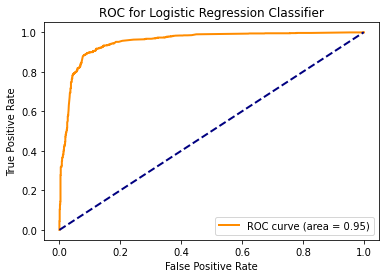

In [14]:
# Since cross-validation results were good, train final model
clf = LogisticRegression(random_state=420).fit(fitted_X_train, Y_train)

# Get train set prediction and probabilities
Y_test_pred = clf.predict(fitted_X_test)
Y_test_proba = clf.predict_proba(fitted_X_test)[:,1]

# Get test set prediction and probabilities
Y_train_pred = clf.predict(fitted_X_train)
Y_train_proba = clf.predict_proba(fitted_X_train)[:,1]


print(confusion_matrix(Y_train, Y_train_pred))
cfm = confusion_matrix(Y_test, Y_test_pred)
print(cfm)
print(classification_report(Y_test, Y_test_pred))
plot_ROC(Y_test, Y_test_proba, 'Logistic Regression Classifier')
model1_precision = cfm[1][1]/(cfm[1][1]+cfm[0][1])
model1_recall = cfm[1][1]/(cfm[1][0]+cfm[1][1])

In [17]:
print("Training set score: {:.3f}".format(clf.score(fitted_X_train, Y_train)))
print("Test set score: {:.3f}".format(clf.score(fitted_X_test, Y_test)))

# Using the statsmodel Logistic Regression to statistically evaluate the parameters
logit_model = sm.Logit(df_Y, df_X)
result = logit_model.fit()
print(result.summary())

Training set score: 0.895
Test set score: 0.895
Optimization terminated successfully.
         Current function value: 0.302550
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                11430
Model:                          Logit   Df Residuals:                    11421
Method:                           MLE   Df Model:                            8
Date:                Thu, 28 Jul 2022   Pseudo R-squ.:                  0.5635
Time:                        19:21:15   Log-Likelihood:                -3458.2
converged:                       True   LL-Null:                       -7922.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
domain_hyphens       0.5227      0.072      7.25

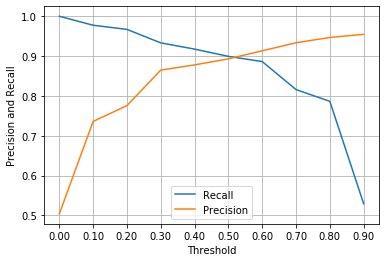

precision accuracy value at 0.3 threshold :  0.8648431214802896
recall accuracy value at 0.3 threshold:  0.9331597222222222


In [82]:
precision_dict, recall_dict = plot_recall_results(Y_test, Y_test_proba)
print('precision accuracy value at 0.3 threshold : ',precision_dict['0.30'])
print('recall accuracy value at 0.3 threshold: ', recall_dict['0.30'])

### Logistic Regression Classifier - Model 2 (Basis RFE)

In [18]:
# Remove string features before doing RFE
df_X1 = df[df.T[df.dtypes!=np.object].index]
df_X1 = df_X1.drop('Y', axis=1)
df_Y1 = df['Y']

In [22]:
df_X1.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,google_index,page_rank,length,is_ip,domain_hyphens,domain_underscores,path_hyphens,path_underscores,slashes,full_stops
0,37,19,0,3,0,0,0,0,0,0,...,1,4,37,0,0,0,0,0,1,11
1,77,23,1,1,0,0,0,0,0,0,...,1,2,77,0,0,0,0,0,3,47
2,126,50,1,4,1,0,1,2,0,3,...,1,0,126,0,1,0,0,0,3,20
3,18,11,0,2,0,0,0,0,0,0,...,0,3,18,0,0,0,0,0,0,0
4,55,15,0,2,2,0,0,0,0,0,...,0,6,55,0,0,0,2,0,3,33


In [23]:
rfc = LogisticRegression(random_state=420)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='recall')
rfecv.fit(df_X1, df_Y1)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(random_state=420), scoring='recall')

In [24]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 53


##### Plot RFE Results

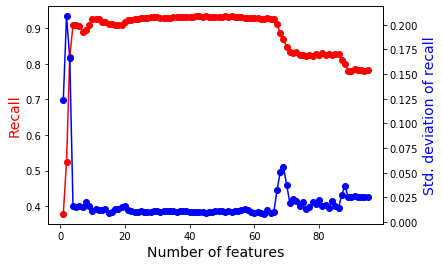

In [25]:

def plot_RFE_results(model, param = 'n_features', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract info from the cross validation model
    test_scores = model.cv_results_['mean_test_score']
    std_test_score = model.cv_results_['std_test_score']
    
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots()
    # make a plot
    ax.plot(range(1,rfecv.n_features_in_ + 1),
            test_scores,
            color="red", 
            marker="o")
    # set x-axis label
    ax.set_xlabel("Number of features", fontsize = 14)
    # set y-axis label
    ax.set_ylabel("Recall",
                  color="red",
                  fontsize=14)

    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(range(1,rfecv.n_features_in_ + 1), std_test_score,color="blue",marker="o")
    ax2.set_ylabel("Std. deviation of recall", color="blue", fontsize=14)
    plt.show()
    
plot_RFE_results(rfecv)

##### Cross-validate using RFE selected features

In [96]:
# Fetching the selected features from RFE
mask = [True if x == 1 else False for x in rfecv.ranking_]
df_X_rfe = df[rfecv.feature_names_in_[mask]]
df_Y_rfe = df['Y']

# Splitting, scaling and training data on the 53 rfe selected variables
X_train_rfe, X_test_rfe, Y_train_rfe, Y_test_rfe = train_test_split(df_X_rfe, df_Y_rfe, test_size=0.2, random_state = 6)

fit = scaler.fit(df_X_rfe)
fitted_X_train_rfe = fit.transform(X_train_rfe)
fitted_X_test_rfe = fit.transform(X_test_rfe)

clf_rfe = LogisticRegression(random_state=420)
scores = cross_validate(clf_rfe, fitted_X_train_rfe, Y_train_rfe,
                        scoring='recall', cv=4, return_train_score = True)
print('Mean train sets Recall for Logistic Regression with RFE: {0:.4f}'.format(scores['train_score'].mean()))
print('Mean test sets Recall for Logistic Regression with RFE: {0:.4f}'.format(scores['test_score'].mean()))


Mean train sets Recall for Logistic Regression with RFE: 0.9249
Mean test sets Recall for Logistic Regression with RFE: 0.9238


##### Train Final Model 

Confusion matrix on train: 
 [[4305  284]
 [ 332 4223]]
Confusion matrix on test: 
 [[1045   81]
 [  76 1084]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1126
           1       0.93      0.93      0.93      1160

    accuracy                           0.93      2286
   macro avg       0.93      0.93      0.93      2286
weighted avg       0.93      0.93      0.93      2286



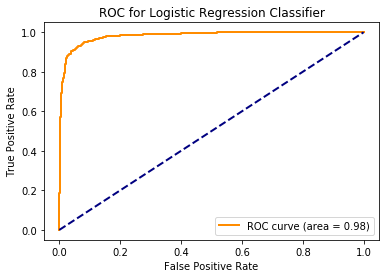

In [97]:
clf_rfe = LogisticRegression(random_state=420).fit(fitted_X_train_rfe, Y_train_rfe)

# Get test set prediction and probabilities
Y_test_pred_rfe = clf_rfe.predict(fitted_X_test_rfe)
Y_test_proba_rfe = clf_rfe.predict_proba(fitted_X_test_rfe)[:,1]  # each class prob?

# Get train set prediction and probabilities
Y_train_pred_rfe = clf_rfe.predict(fitted_X_train_rfe)
Y_train_proba_rfe = clf_rfe.predict_proba(fitted_X_train_rfe)[:,1]

# Evaluate model
print('Confusion matrix on train: \n', confusion_matrix(Y_train_rfe, Y_train_pred_rfe))
cfm = confusion_matrix(Y_test_rfe, Y_test_pred_rfe)
print('Confusion matrix on test: \n', cfm)
print('Classification Report: \n', classification_report(Y_test_rfe, Y_test_pred_rfe))

# Plot ROC
plot_ROC(Y_test_rfe, Y_test_proba_rfe, 'Logistic Regression Classifier')
model2_precision = cfm[1][1]/(cfm[1][1]+cfm[0][1])
model2_recall = cfm[1][1]/(cfm[1][0]+cfm[1][1])

In [98]:
print('Incremental improvement in precision over Model - 1: {0:.4f}'.format(model2_precision - model1_precision))
print('Incremental improvement in recall over Model - 1: {0:.4f}'.format(model2_recall - model1_recall))


Incremental improvement in precision over Model - 1: 0.0374
Incremental improvement in recall over Model - 1: 0.0352


##### Threshold Analysis

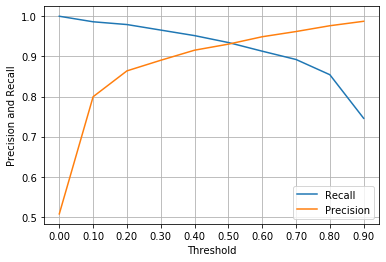

precision accuracy value at 0.3 threshold :  0.890302066772655
recall accuracy value at 0.3 threshold:  0.9655172413793104


In [99]:
# We want a high recall since we do not want to miss out on flagging a phishing website
# Precision should be ~90% even if we reduce threshold to increase recall

precision_dict, recall_dict = plot_recall_results(Y_test_rfe, Y_test_proba_rfe)
print('precision accuracy value at 0.3 threshold : ',precision_dict['0.30'])
print('recall accuracy value at 0.3 threshold: ', recall_dict['0.30'])
precision_thresh =  precision_dict['0.30']
recall_thresh =  recall_dict['0.30']

In [100]:
# New precision and recall at 0.3 threshold
print('Change in precision after changing threshold: {0:.4f}'.format(precision_thresh - model2_precision))
print('Change in recall after changing threshold: {0:.4f}'.format(recall_thresh - model2_recall))

Change in precision after changing threshold: -0.0402
Change in recall after changing threshold: 0.0310


### Naives Bayes Classifier

In [32]:
# Cross-validate on train data
clf = MultinomialNB()
scores = cross_validate(clf, fitted_X_train, Y_train,
                        scoring='recall', cv=4, return_train_score = True)
print('Cross-validation on the train dataset:')
print('Mean train dataset\'s Recall for Naive Bayes Classifier : {0:.4f}'.format(scores['train_score'].mean()))
print('Mean test dataset\'s Recall for Naive Bayes Classifier  : {0:.4f}'.format(scores['test_score'].mean()))

Cross-validation on the train dataset:
Mean train dataset's Recall for Naive Bayes Classifier : 0.9243
Mean test dataset's Recall for Naive Bayes Classifier  : 0.9244


#### Performing Naives Bayes on the features extracted on the basis of EDA :

confusion_matrix for train dataset: 
 [[3817  764]
 [ 345 4218]]
confusion_matrix for test dataset: 
 [[ 953  181]
 [  88 1064]]
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      1134
           1       0.85      0.92      0.89      1152

    accuracy                           0.88      2286
   macro avg       0.89      0.88      0.88      2286
weighted avg       0.88      0.88      0.88      2286



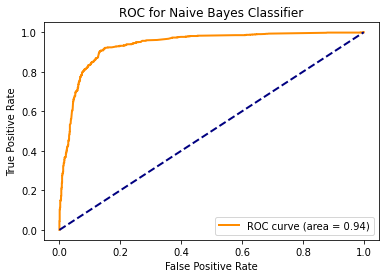

In [33]:
# Since cross-validation results were good, train final model
clf_nb = MultinomialNB().fit(fitted_X_train, Y_train)

# Get train set prediction and probabilities
Y_train_pred_nb = clf_nb.predict(fitted_X_train)
Y_train_proba_nb = clf_nb.predict_proba(fitted_X_train)[:,1]

# Get test set prediction and probabilities
Y_test_pred_nb = clf_nb.predict(fitted_X_test)
Y_test_proba_nb = clf_nb.predict_proba(fitted_X_test)[:,1]

print('confusion_matrix for train dataset: \n',confusion_matrix(Y_train_nb, Y_train_pred_nb))
print('confusion_matrix for test dataset: \n',confusion_matrix(Y_test_nb, Y_test_pred_nb))
print('Classification report: \n',classification_report(Y_test_nb, Y_test_pred_nb))

# ROC curve
plot_ROC(Y_test_nb, Y_test_proba_nb, 'Naive Bayes Classifier')

### Random Forest Model

In [7]:
#Runing Recursive Feature Elimination on the Random Forest
rfc = RandomForestClassifier(random_state=420)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='recall')
rfecv.fit(df_X1, df_Y1)

NameError: name 'df_X1' is not defined

In [ ]:
#Find out the optimal number of features and make them into a new frame

print('Optimal number of features: {}'.format(rfecv.n_features_))

mask = [True if x == 1  else False for x in rfecv.ranking_]
df_X_rfe = df[rfecv.feature_names_in_[mask]]
df_Y_rfe = df['Y']

In [ ]:
#Plot results of RFE

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('Recall', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)

plt.show()

In [ ]:
#Set up random search

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint

import numpy as np

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
max_depth.append(None)
bootstrap = [True]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

pprint(random_grid)

In [ ]:
# Run random search

rf = RandomForestRegressor()


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1,scoring ='recall')

rf_random.fit(df_X_rfe, df_Y_rfe)

rf_random.best_params_

In [ ]:
# Narrow down parameters from random search and run a grid search

from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [7,8,9,10,11],
    'max_features': ['auto'],
    'n_estimators': [760,780,800,820,840]
}

rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


grid_search.fit(df_X_rfe, df_Y_rfe)
grid_search.best_params_

In [ ]:
#Fit using recomended parameters from grid search

clf = RandomForestClassifier(n_estimators = 780, max_depth = 11, max_features = 'auto',
                             bootstrap = True, random_state = 18).fit(fitted_X_train, Y_train)
# Get train set prediction and probabilities
Y_test_pred = clf.predict(fitted_X_test)
Y_test_proba = clf.predict_proba(fitted_X_test)[:,1]
# Get test set prediction and probabilities
Y_train_pred = clf.predict(fitted_X_train)
Y_train_proba = clf.predict_proba(fitted_X_train)[:,1]

print(confusion_matrix(Y_train, Y_train_pred))
print(confusion_matrix(Y_test, Y_test_pred))
print(classification_report(Y_test, Y_test_pred))
# ROC curve
plot_ROC(Y_test, Y_test_proba, 'Random Forest Classifier')

In [ ]:
#Fit for earlier RFE model and compare the two
X_train, X_test, Y_train, Y_test = train_test_split(df_X_rfe, df_Y_rfe, test_size=0.2, random_state = 420)

clf = RandomForestClassifier(n_estimators = 800, max_depth = 9, max_features = 'auto',
                             bootstrap = True, random_state = 18).fit(df_X_rfe, df_Y_rfe)
# Get train set prediction and probabilities
Y_test_pred = clf.predict(X_test)
Y_test_proba = clf.predict_proba(X_test)[:,1]
# Get test set prediction and probabilities
Y_train_pred = clf.predict(X_train)
Y_train_proba = clf.predict_proba(X_train)[:,1]

print(confusion_matrix(Y_train, Y_train_pred))
print(confusion_matrix(Y_test, Y_test_pred))
print(classification_report(Y_test, Y_test_pred))
# ROC curve
plot_ROC(Y_test, Y_test_proba, 'Random Forest Classifier')